In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

# Image processing
import cv2
from PIL import Image

# Utility imports
import os
import random
from glob import glob
from datetime import datetime
from typing import Tuple, List, Dict
import gc

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Check GPU availability
print("🖥️ Hardware Configuration:")
print(f"TensorFlow Version: {tf.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"GPU Available (TF): {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"GPU Available (PyTorch): {torch.cuda.is_available()}")

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

🖥️ Hardware Configuration:
TensorFlow Version: 2.18.0
PyTorch Version: 2.6.0+cu124
GPU Available (TF): False
GPU Available (PyTorch): False


In [6]:
from google.colab import drive
import os  # This was missing!

drive.mount('/content/drive')

# Define dataset path - Update this with your actual path
DATASET_PATH = '/content/drive/MyDrive/dataset_ikan/FishImgDataset'
print(f"📂 Dataset Path: {DATASET_PATH}")

# Define paths for train, validation, and test
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 31
MAX_EPOCHS = 50
SAMPLE_SIZE = 1.0

# Check if dataset path exists
if os.path.exists(DATASET_PATH):
    print("✅ Dataset found!")

    # 1) Print out the root folder contents
    print("Root folder contents:", os.listdir(DATASET_PATH))

    # 2) Verify the three key subfolders exist
    for split in ("train", "val", "test"):
        path = os.path.join(DATASET_PATH, split)
        print(f"{split:5s} exists:", os.path.isdir(path))
        # show first few filenames if it exists
        if os.path.isdir(path):
            print(f"  → {split} sample files:", os.listdir(path)[:5])
else:
    print("❌ Dataset path not found. Please check the path.")
    print("Available in MyDrive:", os.listdir('/content/drive/MyDrive'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Dataset Path: /content/drive/MyDrive/dataset_ikan/FishImgDataset
✅ Dataset found!
Root folder contents: ['test', 'val', 'train']
train exists: True
  → train sample files: ['Snakehead', 'Silver Barb', 'Tilapia', 'Pangasius', 'Perch']
val   exists: True
  → val sample files: ['Silver Perch', 'Silver Carp', 'Mullet', 'Pangasius', 'Perch']
test  exists: True
  → test sample files: ['Tilapia', 'Perch', 'Silver Carp', 'Silver Perch', 'Scat Fish']



📁 TRAIN set:
Number of species: 31
Total images: 519
Sample species: ['Snakehead', 'Silver Barb', 'Tilapia', 'Pangasius', 'Perch', 'Silver Carp', 'Silver Perch', 'Tenpounder', 'Scat Fish', 'Long-Snouted Pipefish', 'Indo-Pacific Tarpon', 'Indian Carp', 'Mudfish', 'Jaguar Gapote', 'Green Spotted Puffer', 'Mosquito Fish', 'Mullet', 'Knifefish', 'Janitor Fish', 'Fourfinger Threadfin', 'Gourami', 'Gold Fish', 'Climbing Perch', 'Freshwater Eel', 'Goby', 'Black Spotted Barb', 'Catfish', 'Grass Carp', 'Glass Perchlet', 'Bangus', 'Big Head Carp']

📁 VAL set:
Number of species: 31
Total images: 2675
Sample species: ['Silver Perch', 'Silver Carp', 'Mullet', 'Pangasius', 'Perch', 'Tilapia', 'Scat Fish', 'Snakehead', 'Silver Barb', 'Tenpounder', 'Mosquito Fish', 'Jaguar Gapote', 'Grass Carp', 'Knifefish', 'Green Spotted Puffer', 'Indo-Pacific Tarpon', 'Indian Carp', 'Mudfish', 'Janitor Fish', 'Long-Snouted Pipefish', 'Gourami', 'Glass Perchlet', 'Gold Fish', 'Fourfinger Threadfin', 'Big Head Carp'

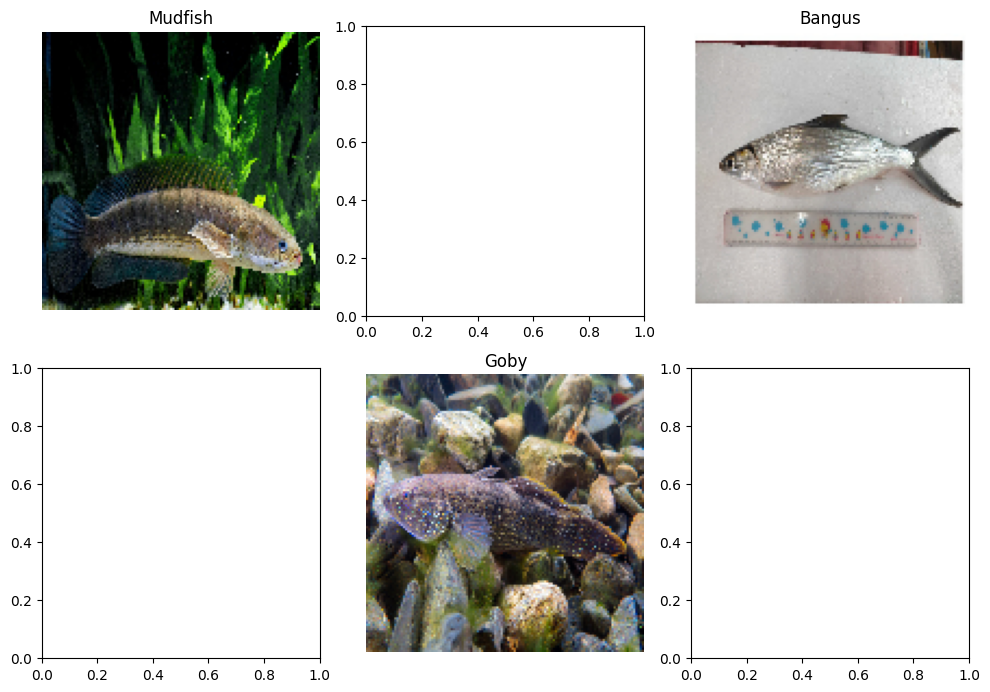

In [8]:
def explore_dataset(base_path: str) -> Dict:
    """
    Explore the fish image dataset structure.
    """
    dataset_info = {
        'train': {},
        'val': {},
        'test': {}
    }

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            species_folders = [f for f in os.listdir(split_path)
                             if os.path.isdir(os.path.join(split_path, f))]

            print(f"\n📁 {split.upper()} set:")
            print(f"Number of species: {len(species_folders)}")

            total_images = 0
            species_counts = {}

            for species in species_folders:
                species_path = os.path.join(split_path, species)
                images = glob(os.path.join(species_path, '*.[jp][pn][g]'))
                species_counts[species] = len(images)
                total_images += len(images)

            dataset_info[split] = {
                'species': species_folders,
                'species_counts': species_counts,
                'total_images': total_images
            }

            print(f"Total images: {total_images}")
            print(f"Sample species: {list(species_counts.keys())}")

    return dataset_info

# Explore the dataset
dataset_info = explore_dataset(DATASET_PATH)

# Create species to index mapping
all_species = sorted(dataset_info['train']['species'])
species_to_idx = {species: idx for idx, species in enumerate(all_species)}
idx_to_species = {idx: species for species, idx in species_to_idx.items()}

print(f"\n🐟 Total fish species: {len(species_to_idx)}")


#Visualize Sample Images (Quick)
def visualize_samples(base_path: str, species_to_idx: Dict, n_samples: int = 6):
    """
    Quickly visualize sample images.
    """
    train_path = os.path.join(base_path, 'train')
    selected_species = random.sample(list(species_to_idx.keys()), min(n_samples, len(species_to_idx)))

    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    axes = axes.flatten()

    for idx, species in enumerate(selected_species[:n_samples]):
        species_path = os.path.join(train_path, species)
        images = glob(os.path.join(species_path, '*.[jp][pn][g]'))

        if images:
            img_path = random.choice(images)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

            axes[idx].imshow(img)
            axes[idx].set_title(f'{species}')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(DATASET_PATH, species_to_idx)